In [ ]:
# !unzip "drive/MyDrive/Colab Notebooks/Fracture.zip" -d "drive/MyDrive/Colab Notebooks/Fracture"

In [ ]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix , classification_report,ConfusionMatrixDisplay

In [ ]:
train_path= 'drive/MyDrive/Colab Notebooks/Fracture/archive (6)/train'
test_path='drive/MyDrive/Colab Notebooks/Fracture/archive (6)/val'

In [ ]:
train_datagen = image.ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (256,256),
    batch_size = 16,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
    test_path,
    target_size = (256,256),
    batch_size = 16,
    shuffle=True,
    class_mode = 'binary')

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 gaussian_noise_5 (Gaussian  (None, 7, 7, 1536)        0         
 Noise)                                                          
                                                                 
 global_average_pooling2d_5  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 512)               786944    
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                     

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy','Precision', 'Recall', 'AUC'])

In [ ]:
lrp = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2)
filepath = 'drive/MyDrive/Colab Notebooks/Fracture/Fracture_CNN.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint, lrp]

history = model.fit(train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=200,
    callbacks=callbacks
)

In [ ]:
model.evaluate(train_generator)

554/554 [==============================] - 181s 326ms/step - loss: 0.0774 - accuracy: 0.9736


[0.07740587741136551, 0.9735981225967407]

In [ ]:
model.evaluate(validation_generator)

38/38 [==============================] - 3s 84ms/step - loss: 1.1284 - accuracy: 0.6883


[1.1283894777297974, 0.6883333325386047]

In [ ]:
# Generate predictions for test data
y_pred = model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int)

# Get ground truth labels
y_true = validation_generator.classes

# Print classification report
print('Classification Report:\n', classification_report(y_true, y_pred))

38/38 [==============================] - 16s 345ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75       360
           1       0.00      0.00      0.00       240

    accuracy                           0.60       600
   macro avg       0.30      0.50      0.37       600
weighted avg       0.36      0.60      0.45       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


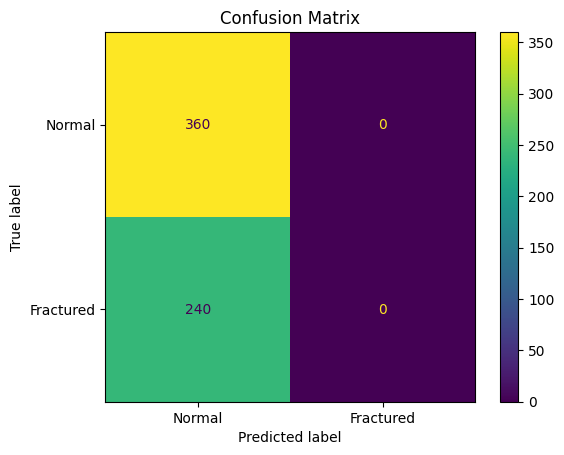

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fractured'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          expand_nested=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    try:
      name = metric.replace("_"," ").capitalize()
      plt.plot(history.epoch, history.history[metric], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      else:
        plt.ylim([0,1])
      plt.legend()
      plt.show()
    except:
      pass

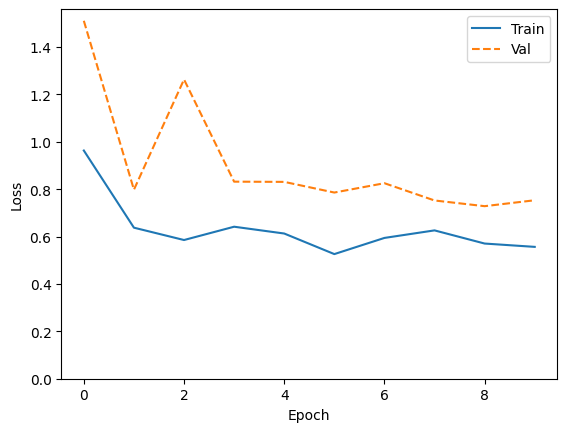

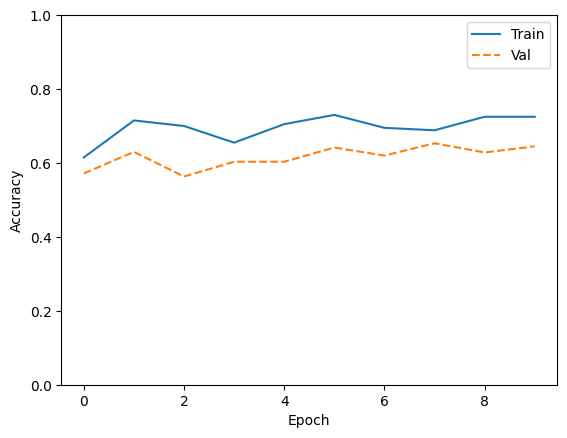

In [ ]:
plot_metrics(history)

1/1 [==============================] - 0s 64ms/step
[[0.271464]]
THE UPLOADED X-RAY IMAGE IS: Fracture


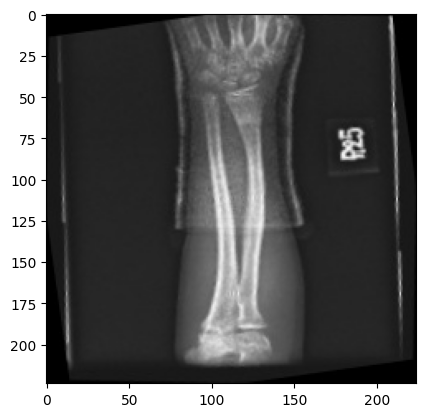

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
img = load_img('drive/MyDrive/Colab Notebooks/Fracture/archive (6)/val/fractured/8-rotated3-rotated1-rotated1.jpg',target_size=(224,224))
imag = img_to_array(img)
imaga = np.expand_dims(imag,axis=0)
ypred = model.predict(imaga)
print(ypred)
a=ypred[0]
if a<0.5:
      op="Fracture"
else:
      op="Normal"
plt.imshow(img)
print("THE UPLOADED X-RAY IMAGE IS: "+str(op))

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define directories
train_path= 'drive/MyDrive/Colab Notebooks/Fracture/archive (6)/train'
test_path='drive/MyDrive/Colab Notebooks/Fracture/archive (6)/val'


# Image dimensions
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)

# Parameters
epochs = 20
batch_size = 4

# Data augmentation for training images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Rescaling for validation and test images
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment training images
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

# Load validation images
validation_generator = valid_test_datagen.flow_from_directory(validation_dir,
                                                               target_size=(img_width, img_height),
                                                               batch_size=batch_size,
                                                               class_mode='binary')

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=epochs,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // batch_size)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/LENOVO/Downloads/archive (22)/archive (6)/train'